In [35]:
import networkx as nx
import osmnx as ox
from matplotlib import pyplot as plt

ox.__version__

'1.9.4'

In [2]:
# Configuration

location = ""
start_point = (-6.255770, 106.849833)
radius_km = 30

trip_times = [15, 30, 45, 60, 90, 120]  # in minutes
default_travel_speed = 5

# Default speeds based on highway type
highway_speeds = {
    "motorway": 60,
    "trunk": 30,
    "primary": 10,
    "secondary": 10,
    "tertiary": 10,
    "residential": 10,
    "living_street": 4,
    "service": 5,
    "unclassified": 5,
    "busway": 50,
}

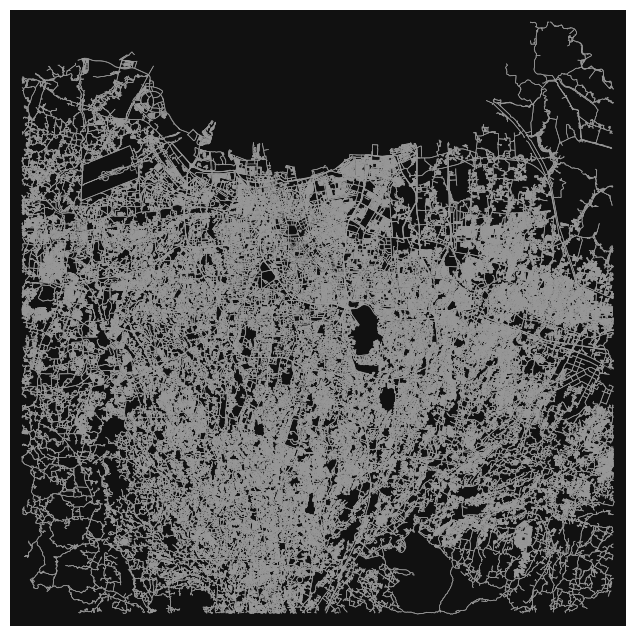

In [3]:
import os

if location:
    cache_file = f"{location}_drive.graphml"
else:
    cache_file = f"{'_'.join(map(lambda x: str(x).replace('.', '_'), start_point))}_{radius_km}_drive.graphml"

# Check if the cache file exists
if os.path.exists(cache_file):
    # Load the graph from the cache file
    G = ox.load_graphml(cache_file)
else:
    # Download the graph and save it to the cache file
    if location:
        G = ox.graph_from_place(location, network_type="drive")
    else:
        G = ox.graph_from_point(center_point=start_point, dist=radius_km*1000, network_type="drive")
    ox.save_graphml(G, cache_file)

fig, ax = ox.plot_graph(G, edge_color='#999999', edge_linewidth=0.5, node_size=0)

C:\Users\adhik\AppData\Roaming\Python\Python312\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


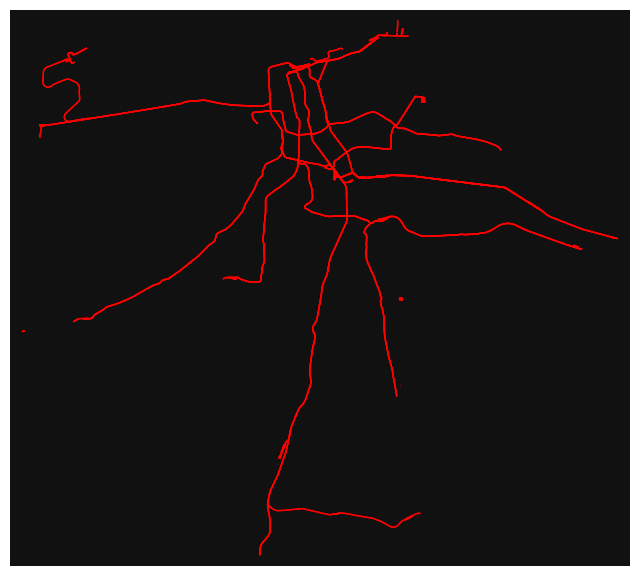

In [65]:
railway_G = ox.graph_from_point(center_point=start_point, dist=radius_km*1000, custom_filter='["railway"]', retain_all=True)
railway_G = ox.project_graph(railway_G)
fig, ax = ox.plot_graph(railway_G, edge_color='#FF0000', edge_linewidth=1, node_size=0)

In [50]:
import requests
from shapely.geometry import Point
import geopandas as gpd

def get_railway_stations(center_point, radius_km):
    # Convert radius to meters
    radius_m = radius_km * 1000
    
    # Overpass API query
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"""
    [out:json];
    (
      node["railway"="station"](around:{radius_m},{center_point[0]},{center_point[1]});
    );
    out center;
    """
    
    # Send request to Overpass API
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()
    
    # Extract station information
    stations = []
    for element in data['elements']:
        if element['type'] == 'node':
            lat, lon = element['lat'], element['lon']
        else:  # way or relation
            lat, lon = element['center']['lat'], element['center']['lon']
        
        name = element['tags'].get('name', 'Unnamed Station')
        stations.append({
            'name': name,
            'geometry': Point(lon, lat)
        })
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(stations, crs="EPSG:4326")
    
    return gdf

# Get railway stations
railway_stations = get_railway_stations(start_point, radius_km)
print(f"Found {len(railway_stations)} railway stations.")


Found 131 railway stations.


In [66]:
from shapely.geometry import LineString

# Project railway stations to the same CRS as G
railway_stations = railway_stations.to_crs(railway_G.graph['crs'])

# Function to add a node to the graph, splitting an edge if necessary
def add_node_to_graph(G, point, node_id):
    nearest_edge = ox.nearest_edges(G, X=[point.x], Y=[point.y])[0]
    u, v, key = nearest_edge
    
    # Get the geometry of the nearest edge
    edge_data = G.edges[u, v, key]
    if 'geometry' not in edge_data:
        # If there's no geometry, create a straight line between the nodes
        start_point = Point(G.nodes[u]['x'], G.nodes[u]['y'])
        end_point = Point(G.nodes[v]['x'], G.nodes[v]['y'])
        edge_geom = LineString([start_point, end_point])
    else:
        edge_geom = edge_data['geometry']
        coords = list(edge_geom.coords)
        line_segments = [LineString([coords[i], coords[i+1]]) for i in range(len(coords)-1)]
        distances = [segment.distance(point) for segment in line_segments]
        nearest_segment = line_segments[distances.index(min(distances))]
        nearest_point = nearest_segment.interpolate(nearest_segment.project(point))
        edge_geom = nearest_segment
    
    # Split the edge at the nearest point
    split_point = edge_geom.interpolate(edge_geom.project(point))
    
    # Create two new geometries
    line1 = LineString([edge_geom.coords[0], split_point.coords[0]])
    line2 = LineString([split_point.coords[0], edge_geom.coords[-1]])
    
    # Add the new node
    G.add_node(node_id, x=point.x, y=point.y, role="station")
    
    # Add new edges
    new_edge_data = edge_data.copy()
    new_edge_data['geometry'] = line1
    G.add_edge(u, node_id, **new_edge_data)
    new_edge_data['geometry'] = line2
    G.add_edge(node_id, v, **new_edge_data)
    
    # Remove the original edge
    # G.remove_edge(u, v, key)

# Add railway stations to the graph
for idx, row in railway_stations.iterrows():
    node_id = f"station_{idx}"
    add_node_to_graph(railway_G, row.geometry, node_id)

print(f"Added {len(railway_stations)} railway stations to the graph.")


c:\Program Files\Python312\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
c:\Program Files\Python312\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Added 131 railway stations to the graph.


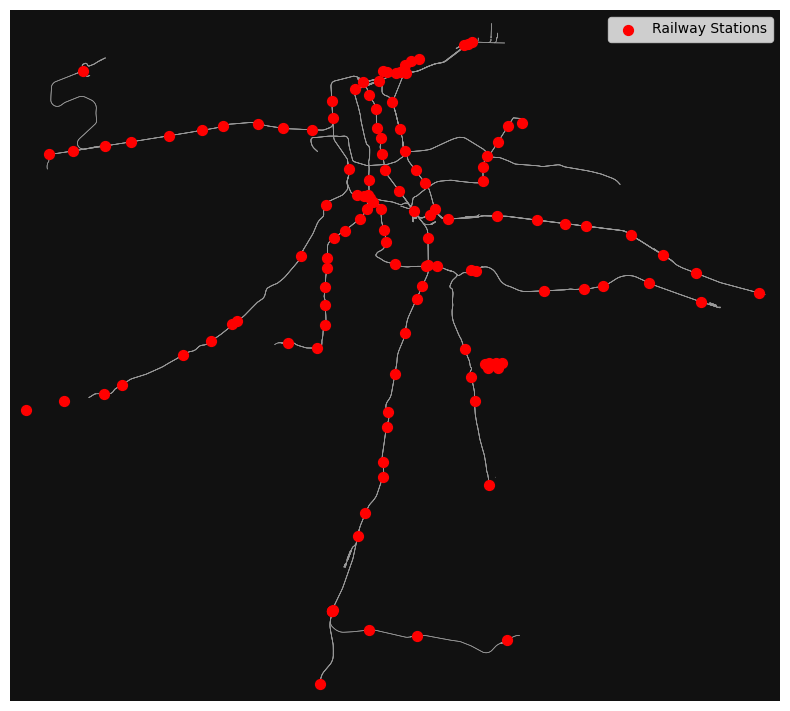

In [67]:
# Plot the railway graph with stations highlighted
fig, ax = ox.plot_graph(railway_G, node_size=0, edge_color='#999999', edge_linewidth=0.5, show=False, close=False)

# Plot station nodes as big red markers
station_nodes = [node for node, data in railway_G.nodes(data=True) if data.get('role') == 'station']
station_coords = [(railway_G.nodes[node]['x'], railway_G.nodes[node]['y']) for node in station_nodes]
x, y = zip(*station_coords)
ax.scatter(x, y, c='red', s=50, zorder=3, label='Railway Stations')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [71]:
# Add 'railway' attribute to all edges in railway_G
for u, v, k, data in railway_G.edges(data=True, keys=True):
    railway_G[u][v][k]['railway'] = 'train'

print(f"Added 'railway' attribute to {railway_G.number_of_edges()} edges in railway_G.")


Added 'railway' attribute to 3372 edges in railway_G.


In [4]:
# Get the center node using global coordinates
center_node = ox.distance.nearest_nodes(G, X=106.849833, Y=-6.255770)
center_coords = G.nodes[center_node]['x'], G.nodes[center_node]['y']
G = ox.project_graph(G)

In [15]:
# Count edges per highway type
highway_type_counts = {}

for _, _, data in G.edges(data=True):
    highway_type = data.get("highway", "unknown")
    if isinstance(highway_type, list):
        highway_type = highway_type[0] if highway_type else "unknown"
    
    if highway_type in highway_type_counts:
        highway_type_counts[highway_type] += 1
    else:
        highway_type_counts[highway_type] = 1

# Print the results
print("Edge counts per highway type:")
for highway_type, count in sorted(highway_type_counts.items()):
    print(f"{highway_type}: {count}")

Edge counts per highway type:
busway: 121
living_street: 241895
motorway: 536
motorway_link: 1091
primary: 13140
primary_link: 1291
residential: 643681
secondary: 18672
secondary_link: 865
tertiary: 55014
tertiary_link: 889
trunk: 3793
trunk_link: 913


In [76]:
# Create a copy of G to work with
road_and_rail_G = G.copy()

# Function to find the nearest edge in railway_G for a given node in G
def find_nearest_railway_edge(node, railway_graph):
    node_point = Point(road_and_rail_G.nodes[node]['x'], road_and_rail_G.nodes[node]['y'])
    min_distance = float('inf')
    nearest_edge = None
    
    for u, v, data in railway_graph.edges(data=True):
        edge_geom = data.get('geometry')
        if edge_geom is None:
            # If 'geometry' is not present, create a LineString from node coordinates
            start_node = railway_graph.nodes[u]
            end_node = railway_graph.nodes[v]
            edge_geom = LineString([(start_node['x'], start_node['y']), (end_node['x'], end_node['y'])])
        else:
            edge_geom = data['geometry']
            coords = list(edge_geom.coords)
            line_segments = [LineString([coords[i], coords[i+1]]) for i in range(len(coords)-1)]
            distances = [segment.distance(node_point) for segment in line_segments]
            nearest_segment = line_segments[distances.index(min(distances))]
            edge_geom = nearest_segment

        distance = node_point.distance(edge_geom)
        if distance < min_distance:
            min_distance = distance
            nearest_edge = (u, v, data)
    
    return nearest_edge, min_distance

# Add railway edges to road_and_rail_G
for u, v, data in railway_G.edges(data=True):
    if not road_and_rail_G.has_edge(u, v):
        road_and_rail_G.add_edge(u, v, **data)

# Connect road nodes to nearest railway edges
from tqdm import tqdm

railway_station_nodes = [n for n, data in railway_G.nodes(data=True) if data.get('railway') == 'train']
for node in tqdm(railway_station_nodes, desc="Processing train stations", unit="station"):
    if node not in road_and_rail_G.nodes():
        nearest_edge, distance = find_nearest_railway_edge(node, railway_G)
        if nearest_edge and distance <= 1000:  # Only connect if within 1000 meters
            u, v, rail_data = nearest_edge
            node_point = Point(road_and_rail_G.nodes[node]['x'], road_and_rail_G.nodes[node]['y'])
            edge_geom = rail_data.get('geometry')
            if edge_geom is None:
                # If 'geometry' is not present, create a LineString from node coordinates
                start_node = railway_G.nodes[u]
                end_node = railway_G.nodes[v]
                edge_geom = LineString([(start_node['x'], start_node['y']), (end_node['x'], end_node['y'])])
            connection_point = edge_geom.interpolate(edge_geom.project(node_point))
            
            # Add new edges connecting the road node to the railway edge
            road_and_rail_G.add_edge(node, u, 
                                     length=distance, 
                                     highway='footway', 
                                     railway='connection',
                                     geometry=LineString([Point(road_and_rail_G.nodes[node]['x'], road_and_rail_G.nodes[node]['y']), connection_point]))
            road_and_rail_G.add_edge(node, v, 
                                     length=distance, 
                                     highway='footway', 
                                     railway='connection',
                                     geometry=LineString([Point(road_and_rail_G.nodes[node]['x'], road_and_rail_G.nodes[node]['y']), connection_point]))

print(f"Combined road and railway networks. Total nodes: {road_and_rail_G.number_of_nodes()}, Total edges: {road_and_rail_G.number_of_edges()}")

Processing nodes:   0%|          | 611/413958 [03:07<35:08:30,  3.27node/s]


KeyboardInterrupt: 

In [5]:
def kmh_to_mpm(kmh):
    return kmh * 1000 / 60

# add an edge attribute for time in minutes required to traverse each edge
for _, _, _, data in G.edges(data=True, keys=True):
    highway_type = data.get("highway", "")
    if isinstance(highway_type, list):
        highway_type = highway_type[0] if highway_type else ""
    speed = highway_speeds.get(highway_type, default_travel_speed)
    
    meters_per_minute = kmh_to_mpm(speed)
    data["time"] = data["length"] / meters_per_minute

# Drop edges that are residential, living_street, service, and unclassified
edges_to_remove = []
for u, v, k, data in G.edges(data=True, keys=True):
    highway_type = data.get("highway", "")
    if isinstance(highway_type, list):
        highway_type = highway_type[0] if highway_type else ""
    if highway_type in ["service", "unclassified"]:
        edges_to_remove.append((u, v, k))

G.remove_edges_from(edges_to_remove)

# Remove any isolated nodes that may have been created by removing edges
G.remove_nodes_from(list(nx.isolates(G)))

In [6]:
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="cividis", start=0)

Time taken for 120 minutes: 13.88 seconds
Time taken for 90 minutes: 10.11 seconds
Time taken for 60 minutes: 5.04 seconds
Time taken for 45 minutes: 1.02 seconds
Time taken for 30 minutes: 0.25 seconds
Time taken for 15 minutes: 0.03 seconds


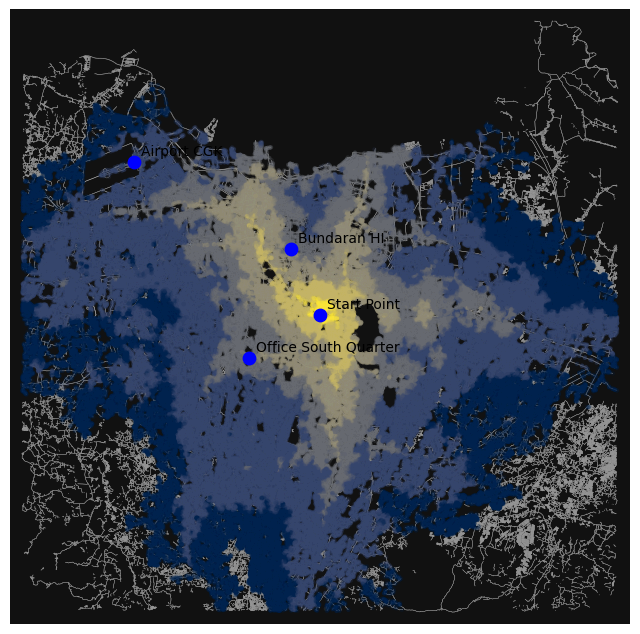

In [13]:
from matplotlib import pyplot as plt
from shapely.geometry import Point
import time

node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    start_time = time.time()
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
    end_time = time.time()
    print(f"Time taken for {trip_time} minutes: {end_time - start_time:.2f} seconds")

nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.2,
    edge_linewidth=0.3,
    edge_color="#999999",
    show=False,
)

poi = {
    "Start Point": (start_point[1], start_point[0]),
    "Office South Quarter": (106.785280, -6.294658),
    "Airport CGK": (106.679671, -6.116638),
    "Bundaran HI": (106.823110, -6.194950),
}

# Add markers for each POI
for name, (lon, lat) in poi.items():
    projected_lon = ox.projection.project_geometry(Point(lon, lat), to_crs=G.graph['crs'])[0].coords[0][0]
    projected_lat = ox.projection.project_geometry(Point(lon, lat), to_crs=G.graph['crs'])[0].coords[0][1]
    ax.scatter(projected_lon, projected_lat, c='blue', s=80, zorder=5, label=name)
    ax.annotate(name, (projected_lon, projected_lat), xytext=(5, 5), textcoords='offset points')

# add labels for each travel time
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color, ec="none", alpha=0.8) 
                   for color in iso_colors]
legend_labels = [f"{time} min" for time in sorted(trip_times, reverse=True)]
ax.legend(legend_elements, legend_labels, loc="upper right", title="Travel Time")

plt.show()

In [14]:
from shapely.geometry import LineString, Point, Polygon, MultiPolygon
import geopandas as gpd
import numpy as np

def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []

    # Pre-compute node geometries
    node_points = [Point((data["x"], data["y"])) for _, data in G.nodes(data=True)]
    nodes_gdf = gpd.GeoDataFrame({"id": list(G.nodes)}, geometry=node_points)
    nodes_gdf = nodes_gdf.set_index("id")
    
    # Pre-compute node buffers if needed
    if node_buff > 0:
        node_buffers = nodes_gdf.buffer(node_buff).geometry
    
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
        
        # Use vectorized operations for edge geometries
        edges = list(subgraph.edges())
        edge_geoms = []
        for n_fr, n_to in edges:
            try:
                edge = G.get_edge_data(n_fr, n_to)
                if len(edge) < 1:
                    continue
                geom = edge[0].get("geometry")
                if geom is None:
                    geom = LineString([nodes_gdf.loc[n_fr].geometry, nodes_gdf.loc[n_to].geometry])
                edge_geoms.append(geom)
            except KeyError:
                # If KeyError occurs, continue to the next iteration
                continue
        
        # Compute edge buffers in bulk
        if edge_buff > 0:
            edge_buffers = gpd.GeoSeries(edge_geoms).buffer(edge_buff)
        else:
            edge_buffers = gpd.GeoSeries(edge_geoms)
        
        # Combine node and edge geometries
        if node_buff > 0:
            all_geoms = list(node_buffers.loc[subgraph.nodes()]) + list(edge_buffers)
        else:
            all_geoms = list(edge_buffers)
        
        new_iso = gpd.GeoSeries(all_geoms).unary_union

        if infill:
            if isinstance(new_iso, MultiPolygon):
                new_iso = max(new_iso.geoms, key=lambda p: p.area)
            if isinstance(new_iso, Polygon):
                new_iso = Polygon(new_iso.exterior)
        
        isochrone_polys.append(new_iso)
    
    return isochrone_polys

# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=100, node_buff=0, infill=False)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)

# add center node
center_node_coords = G.nodes[center_node]
ax.scatter(center_node_coords['x'], center_node_coords['y'], c='red', s=50, zorder=5)

# add labels for each travel time
# Create a legend instead of annotations
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color, ec="none", alpha=0.8) 
                   for color in iso_colors]
legend_labels = [f"{time} min" for time in sorted(trip_times, reverse=True)]
ax.legend(legend_elements, legend_labels, loc="upper right", title="Travel Time")

plt.show()